In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

100%|██████████| 82.0M/82.0M [01:11<00:00, 1.20MB/s]

Extracting files...


Path to dataset files: C:\Users\trh00\.cache\kagglehub\datasets\olgabelitskaya\horse-breeds\versions\27


In [2]:
import os

root = r'C:\Users\trh00\.cache\kagglehub\datasets\olgabelitskaya\horse-breeds\versions\27'
images = os.listdir(root)
images[:5]

['01_001.png', '01_002.png', '01_003.png', '01_004.png', '01_005.png']

In [3]:
# split into training and test
import random
random.seed(4)
random.shuffle(images)
split = int(0.8 * len(images))
train_images = images[:split]
test_images = images[split:]

print("Number of training images:", len(train_images))
print("Number of test images:", len(test_images))

Number of training images: 536
Number of test images: 134


In [4]:
import torch
from torch.utils.data import Dataset
# create transform
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

class HorseBreedDataset(Dataset):
    def __init__(self, root, images, transform_input=None, transform_target=None):
        self.root = root
        self.images = images
        self.transform_input = transform_input
        self.transform_target = transform_target

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.root, self.images[idx]))
        input_image = self.transform_input(image)
        target = int(images[idx].split('_')[0])
        target = target - 1
        target = torch.tensor(target)
        return input_image[:3, :, :], target
    
train_dataset = HorseBreedDataset(root, train_images, transform_input=transform)
test_dataset = HorseBreedDataset(root, test_images, transform_input=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



In [5]:
for input_image, target in train_loader:
    print(input_image.shape, target)
    break

torch.Size([32, 3, 256, 256]) tensor([1, 5, 5, 0, 5, 4, 5, 6, 5, 0, 6, 5, 6, 5, 5, 6, 6, 1, 4, 0, 2, 0, 1, 5,
        1, 1, 1, 5, 6, 2, 1, 1])


In [28]:
import torch.nn as nn
import torch

# Define the CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Activation
        self.relu = nn.ReLU()
        
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(65536, 128)
        self.fc2 = nn.Linear(128, 7)  # 10 output classes for CIFAR-10

    def forward(self, x):
        # original shape 1, 250, 90
        # Convolution + ReLU + Pooling
        x = self.pool(self.relu(self.conv1(x)))  #  16, 125, 45
        x = self.pool(self.relu(self.conv2(x)))  # 32, 62, 22 
        x = self.pool(self.relu(self.conv3(x)))  # 64, 31, 11 
        
        # Flatten
        x = x.view(x.size(0), -1)  # (Batch, 64*4*4)
        
        # Fully Connected Layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Logits
        
        return x                # Although this is a classification problem, we didn't apply softmax. Do you know why?👀 (Hint: CrossEntropyLoss has something to do here👀)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)


In [6]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [30]:
import torch.optim as optim

# Initialize the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adam optimizer
num_epochs = 20 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch 1/20: Train Loss=1.8882, Train Accuracy=25.00%, Val Loss=1.9232, Val Accuracy=23.13%


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch 2/20: Train Loss=1.8289, Train Accuracy=30.78%, Val Loss=1.9218, Val Accuracy=22.39%


100%|██████████| 17/17 [00:07<00:00,  2.18it/s]


Epoch 3/20: Train Loss=1.7323, Train Accuracy=31.53%, Val Loss=1.9729, Val Accuracy=19.40%


100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


Epoch 4/20: Train Loss=1.5990, Train Accuracy=41.23%, Val Loss=2.0060, Val Accuracy=16.42%


100%|██████████| 17/17 [00:08<00:00,  2.10it/s]


Epoch 5/20: Train Loss=1.4851, Train Accuracy=42.72%, Val Loss=2.1477, Val Accuracy=19.40%


100%|██████████| 17/17 [00:07<00:00,  2.38it/s]


Epoch 6/20: Train Loss=1.3554, Train Accuracy=47.39%, Val Loss=2.2530, Val Accuracy=14.93%


100%|██████████| 17/17 [00:07<00:00,  2.42it/s]


Epoch 7/20: Train Loss=1.2481, Train Accuracy=55.78%, Val Loss=2.4628, Val Accuracy=12.69%


100%|██████████| 17/17 [00:06<00:00,  2.52it/s]


Epoch 8/20: Train Loss=1.1369, Train Accuracy=57.28%, Val Loss=2.6587, Val Accuracy=20.15%


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


Epoch 9/20: Train Loss=1.0699, Train Accuracy=61.94%, Val Loss=2.7545, Val Accuracy=15.67%


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch 10/20: Train Loss=0.9912, Train Accuracy=66.79%, Val Loss=2.9159, Val Accuracy=17.91%


100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


Epoch 11/20: Train Loss=0.9548, Train Accuracy=65.67%, Val Loss=2.8785, Val Accuracy=14.93%


100%|██████████| 17/17 [00:07<00:00,  2.37it/s]


Epoch 12/20: Train Loss=0.8712, Train Accuracy=68.10%, Val Loss=2.9074, Val Accuracy=15.67%


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch 13/20: Train Loss=0.7205, Train Accuracy=79.66%, Val Loss=3.0529, Val Accuracy=17.16%


100%|██████████| 17/17 [00:06<00:00,  2.47it/s]


Epoch 14/20: Train Loss=0.6693, Train Accuracy=80.97%, Val Loss=3.3588, Val Accuracy=16.42%


100%|██████████| 17/17 [00:06<00:00,  2.44it/s]


Epoch 15/20: Train Loss=0.5768, Train Accuracy=82.65%, Val Loss=3.3991, Val Accuracy=17.91%


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch 16/20: Train Loss=0.5312, Train Accuracy=85.07%, Val Loss=3.5850, Val Accuracy=19.40%


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch 17/20: Train Loss=0.4857, Train Accuracy=85.63%, Val Loss=3.7767, Val Accuracy=17.91%


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch 18/20: Train Loss=0.4116, Train Accuracy=88.06%, Val Loss=3.9748, Val Accuracy=17.91%


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch 19/20: Train Loss=0.3614, Train Accuracy=90.49%, Val Loss=4.0626, Val Accuracy=17.91%


100%|██████████| 17/17 [00:07<00:00,  2.25it/s]


Epoch 20/20: Train Loss=0.2863, Train Accuracy=94.78%, Val Loss=4.3242, Val Accuracy=16.42%


## try it in a pretrained model

In [10]:
from torchvision.models import resnet50
import torch.nn as nn

model = resnet50(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# freeze all layers
# for param in model.parameters():
#     param.requires_grad = False

# model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(2048, 7)  # Change output layer to 7 classes

model = model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch.optim as optim

# Initialize the model

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Multi-class Classification loss (Input: Logits, not probabilities)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 17/17 [00:27<00:00,  1.60s/it]


Epoch 1/10: Train Loss=1.1321, Train Accuracy=64.55%, Val Loss=3.6819, Val Accuracy=14.93%


100%|██████████| 17/17 [00:24<00:00,  1.46s/it]


Epoch 2/10: Train Loss=0.2401, Train Accuracy=95.90%, Val Loss=4.4027, Val Accuracy=14.93%


100%|██████████| 17/17 [00:27<00:00,  1.60s/it]


Epoch 3/10: Train Loss=0.0535, Train Accuracy=99.81%, Val Loss=4.8023, Val Accuracy=14.93%


100%|██████████| 17/17 [00:26<00:00,  1.57s/it]


Epoch 4/10: Train Loss=0.0272, Train Accuracy=100.00%, Val Loss=5.1211, Val Accuracy=14.93%


100%|██████████| 17/17 [00:25<00:00,  1.50s/it]


Epoch 5/10: Train Loss=0.0129, Train Accuracy=100.00%, Val Loss=5.5127, Val Accuracy=15.67%


100%|██████████| 17/17 [00:24<00:00,  1.46s/it]


Epoch 6/10: Train Loss=0.0076, Train Accuracy=100.00%, Val Loss=5.5698, Val Accuracy=16.42%


100%|██████████| 17/17 [00:26<00:00,  1.55s/it]


Epoch 7/10: Train Loss=0.0058, Train Accuracy=100.00%, Val Loss=5.6126, Val Accuracy=15.67%


100%|██████████| 17/17 [00:26<00:00,  1.54s/it]


Epoch 8/10: Train Loss=0.0058, Train Accuracy=100.00%, Val Loss=5.7730, Val Accuracy=16.42%


 71%|███████   | 12/17 [00:21<00:09,  1.81s/it]


KeyboardInterrupt: 

In [53]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss={test_loss:.4f}, Test Accuracy={test_accuracy:.2f}%")

Test Loss=3.5675, Test Accuracy=16.42%


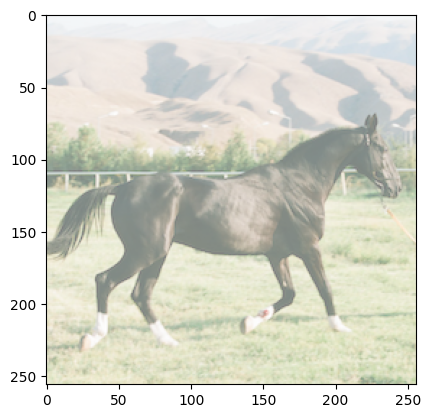

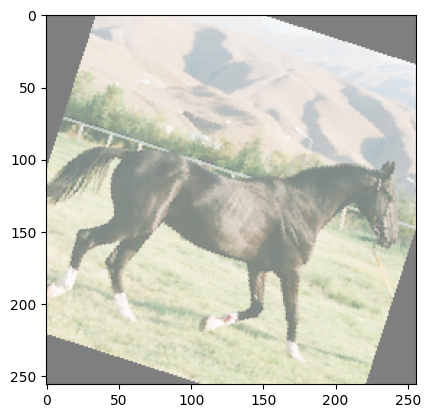

In [17]:
import torch
import torchvision
img = 0
for imgs, target in test_loader:
    img = imgs[0]
    break
img_before = img



img_after = transforms.RandomRotation(30)(img)

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(img_before))
imshow(torchvision.utils.make_grid(img_after))
